Shape: (28, 32)
Columns: ['Timestamp', 'age', 'gender', 'family_status', 'educational_level', 'field_study', 'area', 'years_experience', 'migration_pathway', 'time_residency', 'local_language_proficiency', 'currently_work_field', 'difficult_find_job_field', 'alternative_job', 'factors_job_placement', 'monthly_income', 'career_progressed_since_migrating', 'professional_situation', 'resources_ advance_professionally', 'current_professional_development', 'opportunities_accessed', 'barriers_career_development', 'received_support _community', 'If the question before was yes, please specify which one(s)', 'time_stabilize_career', 'migration_impacted_wellbeing', 'support_network', 'adapt_professional_environment', 'affected_emotional_well-being', 'personal_strategies', 'recommendation_other_immigrants', 'email']


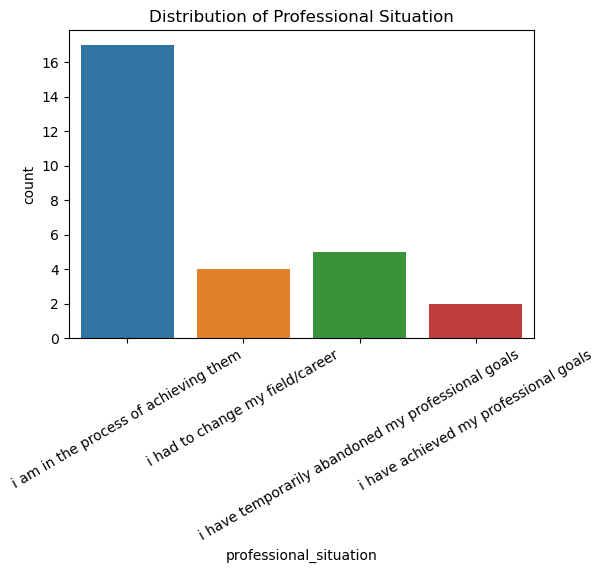

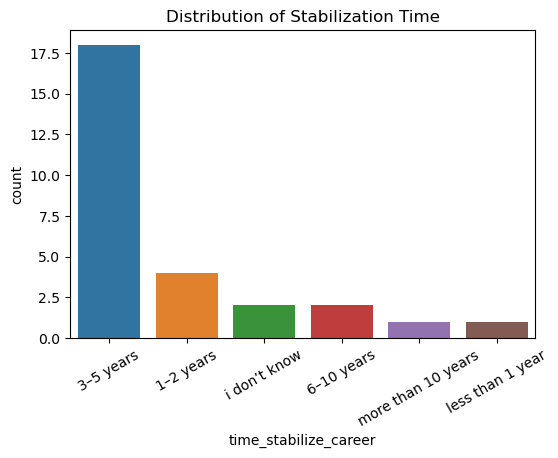

Chi2 p-value (career success vs support network): 0.18615185223771538

Significant predictors for Career Success: ['currently_work_field', 'monthly_income', 'career_progressed_since_migrating', 'resources_ advance_professionally']

Significant predictors for Stabilization Time: ['time_residency', 'factors_job_placement', 'monthly_income', 'opportunities_accessed', 'adapt_professional_environment']

Career Success Model
                                       precision    recall  f1-score   support

i am in the process of achieving them       1.00      1.00      1.00         6

                             accuracy                           1.00         6
                            macro avg       1.00      1.00      1.00         6
                         weighted avg       1.00      1.00      1.00         6

Accuracy: 1.0


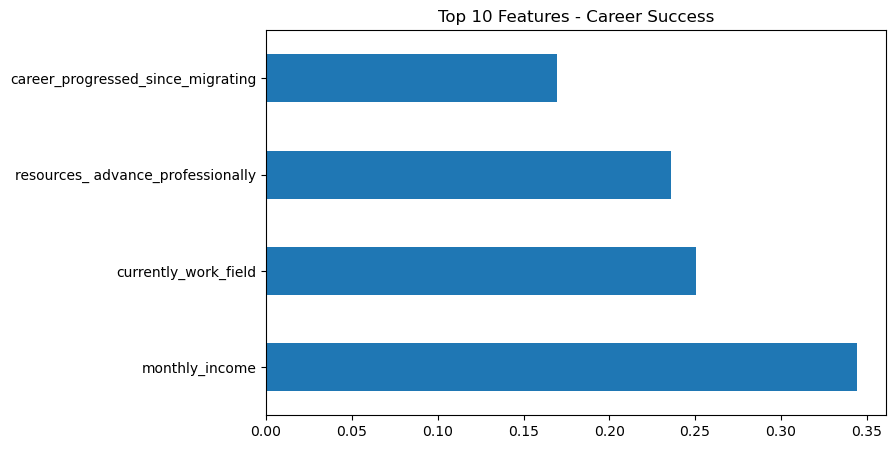


Stabilization Time Model
              precision    recall  f1-score   support

   1–2 years       0.50      1.00      0.67         1
   3–5 years       0.67      0.50      0.57         4
  6–10 years       0.00      0.00      0.00         0
i don’t know       0.00      0.00      0.00         1

    accuracy                           0.50         6
   macro avg       0.29      0.38      0.31         6
weighted avg       0.53      0.50      0.49         6

Accuracy: 0.5


/home/5dceafcf-ed1f-4fd3-9d61-9e0c56cf177c/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/5dceafcf-ed1f-4fd3-9d61-9e0c56cf177c/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/5dceafcf-ed1f-4fd3-9d61-9e0c56cf177c/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

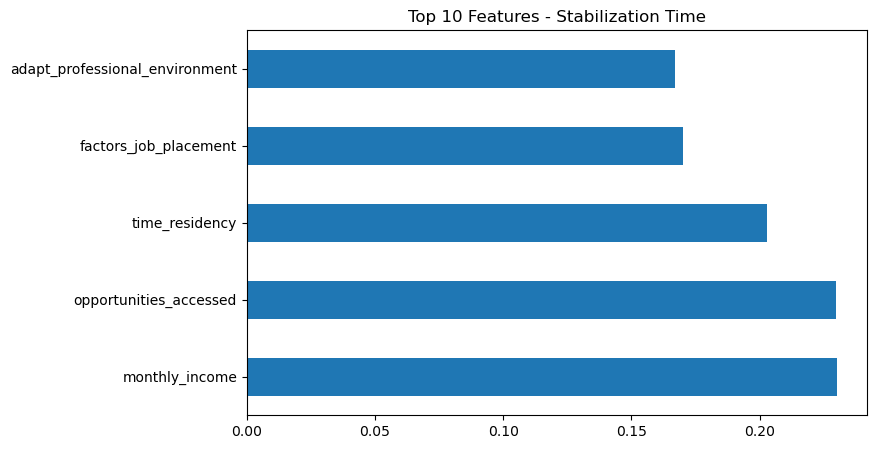

✅ Models, encoders, and feature selection completed!


In [9]:
# ======================
# 1. Import libraries
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

# ======================
# 2. Load dataset
# ======================
df = pd.read_excel("CareerDevelopmentSurvey.xlsx", sheet_name="Form Responses 1")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

# ======================
# 3. Drop irrelevant columns
# ======================
df = df.drop(columns=["Timestamp", "personal_strategies", "recommendation_other_immigrants", "email"], errors="ignore")

# ======================
# 4. Handle missing values
# ======================
df = df.fillna("Unknown")

# ======================
# 5. Normalize categories (optional cleaning)
# ======================
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

if "gender" in df.columns:
    df["gender"] = df["gender"].replace({
        "male": "male",
        "m": "male",
        "female": "female",
        "f": "female"
    })

# ======================
# 6. Quick EDA
# ======================
plt.figure(figsize=(6,4))
sns.countplot(x="professional_situation", data=df)
plt.title("Distribution of Professional Situation")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="time_stabilize_career", data=df)
plt.title("Distribution of Stabilization Time")
plt.xticks(rotation=30)
plt.show()

# Example Chi2 test
if "support_network" in df.columns:
    contingency = pd.crosstab(df["professional_situation"], df["support_network"])
    chi2, p, dof, ex = chi2_contingency(contingency)
    print("Chi2 p-value (career success vs support network):", p)

# ======================
# 7. Encode categorical variables
# ======================
encoders = {}
for col in df.columns:
    if col not in ["professional_situation", "time_stabilize_career"]:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

# ======================
# 8. Chi-Square Feature Selection
# ======================
def chi_square_selection(df, target):
    significant_vars = []
    for col in df.columns:
        if col != target and col not in ["professional_situation", "time_stabilize_career"]:
            contingency = pd.crosstab(df[target], df[col])
            chi2, p, dof, ex = chi2_contingency(contingency)
            if p < 0.05:  # significant at 95% confidence
                significant_vars.append(col)
    return significant_vars

sig_vars_success = chi_square_selection(df, "professional_situation")
print("\nSignificant predictors for Career Success:", sig_vars_success)

sig_vars_stab = chi_square_selection(df, "time_stabilize_career")
print("\nSignificant predictors for Stabilization Time:", sig_vars_stab)

# ======================
# 9. Model 1 - Career Success
# ======================
y1 = df["professional_situation"]
X1 = df[sig_vars_success]  # only significant predictors

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

model1 = RandomForestClassifier(n_estimators=200, random_state=42)
model1.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)
print("\nCareer Success Model")
print(classification_report(y_test, y_pred1))
print("Accuracy:", accuracy_score(y_test, y_pred1))

# Feature importance
importances = pd.Series(model1.feature_importances_, index=X1.columns)
importances.nlargest(10).plot(kind="barh", figsize=(8,5))
plt.title("Top 10 Features - Career Success")
plt.show()

joblib.dump(model1, "career_success_model.pkl")

# ======================
# 10. Model 2 - Stabilization Time
# ======================
y2 = df["time_stabilize_career"]
X2 = df[sig_vars_stab]  # only significant predictors

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

model2 = RandomForestClassifier(n_estimators=200, random_state=42)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)
print("\nStabilization Time Model")
print(classification_report(y_test, y_pred2))
print("Accuracy:", accuracy_score(y_test, y_pred2))

# Feature importance
importances = pd.Series(model2.feature_importances_, index=X2.columns)
importances.nlargest(10).plot(kind="barh", figsize=(8,5))
plt.title("Top 10 Features - Stabilization Time")
plt.show()

joblib.dump(model2, "stabilization_time_model.pkl")

# ======================
# 11. Save encoders
# ======================
joblib.dump(encoders, "encoders.pkl")

print("✅ Models, encoders, and feature selection completed!")
